In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load and preprocess data
data = pd.read_csv('tsla.csv')
if 'day_total_vol' in data.columns:
    data['day_total_vol'] = data['day_total_vol'] / 10000000

data['Date'] = pd.to_datetime(data['date'])
data['Volume'] = data['TSLA_first_hour_vol']  # Predicting first hour volume
data['SentimentImpact'] = data['abs_sentiment_score'] * data['news_count']

# Create lag features for past 5 days using 'day_total_vol'
for lag in range(1, 6):
    data[f'DayTotalVol_Lag_{lag}'] = data['day_total_vol'].shift(lag)

# Drop rows with NaN values due to lagging
data.dropna(inplace=True)

# Split data into training and testing sets
train_data = data[(data['Date'] >= '2024-01-01') & (data['Date'] <= '2024-09-30')]
test_data = data[(data['Date'] >= '2024-10-01') & (data['Date'] <= '2024-12-31')].copy()

# Define features and target
features = ['SentimentImpact', 'DayTotalVol_Lag_1', 'DayTotalVol_Lag_2', 'DayTotalVol_Lag_3', 'DayTotalVol_Lag_4', 'DayTotalVol_Lag_5']
target = 'Volume'

# Train the model
model = RandomForestRegressor(n_estimators=10000, random_state=500)
model.fit(train_data[features], train_data[target])

# Feature Importance and Ranking
feature_importance = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
feature_importance_rank = feature_importance.rank(ascending=False)

print("\nFeature Importance:")
print(feature_importance)
print("\nFeature Importance Rank:")
print(feature_importance_rank)

# Testing and rolling prediction
test_dates = test_data['Date'].unique()
results = []
all_predictions = []
all_actuals = []

for date in test_dates:
    current_data = test_data[test_data['Date'] == date]
    prediction = model.predict(current_data[features])
    actual = current_data[target].values

    all_predictions.extend(prediction)
    all_actuals.extend(actual)

    mse = mean_squared_error(actual, prediction)
    r2 = r2_score(actual, prediction)

    for i in range(len(actual)):
        results.append({
            'Date': date, 
            'Actual_Volume': actual[i], 
            'Predicted_Volume': prediction[i], 
            'Difference': actual[i] - prediction[i]
        })

    print(f"Date: {date}")
    print(f"Predicted Value: {prediction}")
    print(f"Actual Value: {actual}")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared Score: {r2}")
    print("\n")
    
    # Update the lag features with actual values for rolling prediction
    for idx, row in current_data.iterrows():
        future_mask = (test_data['Date'] > date)

        for lag in range(5, 1, -1):
            current_values = test_data.loc[test_data['Date'] == date, f'DayTotalVol_Lag_{lag-1}'].values

            if len(current_values) > 0:
                test_data.loc[future_mask, f'DayTotalVol_Lag_{lag}'] = current_values[0]

        if idx < len(actual):
            test_data.loc[future_mask, 'DayTotalVol_Lag_1'] = actual[idx]

# Overall metrics for the whole testing period
overall_mse = mean_squared_error(all_actuals, all_predictions)
overall_r2 = r2_score(all_actuals, all_predictions)
overall_mae = mean_absolute_error(all_actuals, all_predictions)

print(f"\nOverall Mean Squared Error: {overall_mse}")
print(f"Overall R-squared Score: {overall_r2}")
print(f"Overall Mean Absolute Error: {overall_mae}")

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

# Save the results to a CSV file
results_df.to_csv('tsla_prediction_results.csv', index=False)



Feature Importance:
SentimentImpact      0.408536
DayTotalVol_Lag_1    0.337256
DayTotalVol_Lag_2    0.074493
DayTotalVol_Lag_4    0.064485
DayTotalVol_Lag_5    0.063113
DayTotalVol_Lag_3    0.052117
dtype: float64

Feature Importance Rank:
SentimentImpact      1.0
DayTotalVol_Lag_1    2.0
DayTotalVol_Lag_2    3.0
DayTotalVol_Lag_4    4.0
DayTotalVol_Lag_5    5.0
DayTotalVol_Lag_3    6.0
dtype: float64


C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-10-01T00:00:00.000000000
Predicted Value: [2.4718329]
Actual Value: [2.5533756]
Mean Squared Error: 0.006649211639535791
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-10-02T00:00:00.000000000
Predicted Value: [3.10048371]
Actual Value: [3.8780956]
Mean Squared Error: 0.6046802515473919
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-10-03T00:00:00.000000000
Predicted Value: [2.79654644]
Actual Value: [2.1382081]
Mean Squared Error: 0.43340936571364586
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-10-04T00:00:00.000000000
Predicted Value: [2.99300349]
Actual Value: [2.7428791]
Mean Squared Error: 0.06256221076304479
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-10-07T00:00:00.000000000
Predicted Value: [2.63080646]
Actual Value: [1.9605808]
Mean Squared Error: 0.4492024330168122
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-10-08T00:00:00.000000000
Predicted Value: [2.20589661]
Actual Value: [1.9201124]
Mean Squared Error: 0.08167261612002231
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-10-09T00:00:00.000000000
Predicted Value: [2.17580992]
Actual Value: [2.203075]
Mean Squared Error: 0.0007433844461671447
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-10-10T00:00:00.000000000
Predicted Value: [2.37677781]
Actual Value: [3.1783416]
Mean Squared Error: 0.6425045146970861
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-10-11T00:00:00.000000000
Predicted Value: [4.25038261]
Actual Value: [6.3796985]
Mean Squared Error: 4.533986145012369
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-10-14T00:00:00.000000000
Predicted Value: [4.35150512]
Actual Value: [3.8071963]
Mean Squared Error: 0.2962720888299135
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-10-15T00:00:00.000000000
Predicted Value: [2.83376647]
Actual Value: [2.6328427]
Mean Squared Error: 0.040370363316093665
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-10-16T00:00:00.000000000
Predicted Value: [2.29084852]
Actual Value: [2.0003609]
Mean Squared Error: 0.08438305697243606
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-10-17T00:00:00.000000000
Predicted Value: [2.27828171]
Actual Value: [1.812205]
Mean Squared Error: 0.2172275023917049
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-10-18T00:00:00.000000000
Predicted Value: [2.34076984]
Actual Value: [1.709092]
Mean Squared Error: 0.39901688827914694
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-10-21T00:00:00.000000000
Predicted Value: [2.29108917]
Actual Value: [1.9608678]
Mean Squared Error: 0.10904615244527757
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-10-22T00:00:00.000000000
Predicted Value: [2.52055782]
Actual Value: [1.3147497]
Mean Squared Error: 1.453973226888414
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-10-23T00:00:00.000000000
Predicted Value: [2.51579302]
Actual Value: [1.4735216]
Mean Squared Error: 1.086329716471802
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-10-24T00:00:00.000000000
Predicted Value: [4.03895451]
Actual Value: [7.3391487]
Mean Squared Error: 10.891281676529958
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-10-25T00:00:00.000000000
Predicted Value: [4.84038398]
Actual Value: [5.8550919]
Mean Squared Error: 1.029632169242202
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-10-28T00:00:00.000000000
Predicted Value: [5.50852917]
Actual Value: [3.6117081]
Mean Squared Error: 3.597930184647821
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-10-29T00:00:00.000000000
Predicted Value: [3.14479507]
Actual Value: [2.4343613]
Mean Squared Error: 0.5047161462311139
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-10-30T00:00:00.000000000
Predicted Value: [3.05273723]
Actual Value: [1.6915416]
Mean Squared Error: 1.8528535369779864
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-10-31T00:00:00.000000000
Predicted Value: [2.37612238]
Actual Value: [1.9660364]
Mean Squared Error: 0.16817050977876924
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-11-01T00:00:00.000000000
Predicted Value: [2.18388377]
Actual Value: [1.5793046]
Mean Squared Error: 0.3655159706940859
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-11-04T00:00:00.000000000
Predicted Value: [2.27731959]
Actual Value: [2.4784421]
Mean Squared Error: 0.04045026450329435
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-11-05T00:00:00.000000000
Predicted Value: [2.41895758]
Actual Value: [2.3729856]
Mean Squared Error: 0.002113422687680118
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-11-06T00:00:00.000000000
Predicted Value: [3.16280857]
Actual Value: [7.7672528]
Mean Squared Error: 21.200906676666918
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-11-07T00:00:00.000000000
Predicted Value: [5.22742176]
Actual Value: [3.7395667]
Mean Squared Error: 2.2137126652552754
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-11-08T00:00:00.000000000
Predicted Value: [3.81102156]
Actual Value: [5.1742915]
Mean Squared Error: 1.8585049227368766
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-11-11T00:00:00.000000000
Predicted Value: [5.43749994]
Actual Value: [7.0028742]
Mean Squared Error: 2.450396560971119
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-11-12T00:00:00.000000000
Predicted Value: [5.14354477]
Actual Value: [4.9876702]
Mean Squared Error: 0.02429688050661239
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-11-13T00:00:00.000000000
Predicted Value: [5.14641327]
Actual Value: [4.7601829]
Mean Squared Error: 0.14917390061091418
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-11-14T00:00:00.000000000
Predicted Value: [3.42682228]
Actual Value: [3.3559892]
Mean Squared Error: 0.0050173250466222195
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-11-15T00:00:00.000000000
Predicted Value: [2.94544038]
Actual Value: [3.9399744]
Mean Squared Error: 0.9890979196225382
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-11-18T00:00:00.000000000
Predicted Value: [4.31611714]
Actual Value: [4.5067823]
Mean Squared Error: 0.036353204908007516
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-11-19T00:00:00.000000000
Predicted Value: [3.50583294]
Actual Value: [2.7783154]
Mean Squared Error: 0.5292817696109483
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-11-20T00:00:00.000000000
Predicted Value: [2.63630499]
Actual Value: [2.203258]
Mean Squared Error: 0.18752969482927226
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-11-21T00:00:00.000000000
Predicted Value: [2.33597981]
Actual Value: [2.2500104]
Mean Squared Error: 0.00739073977556856
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-11-22T00:00:00.000000000
Predicted Value: [2.10277091]
Actual Value: [2.1004015]
Mean Squared Error: 5.614105691572183e-06
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-11-25T00:00:00.000000000
Predicted Value: [3.22771085]
Actual Value: [3.2041892]
Mean Squared Error: 0.0005532680638811768
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-11-26T00:00:00.000000000
Predicted Value: [3.07869768]
Actual Value: [2.1704507]
Mean Squared Error: 0.8249125829094764
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-11-27T00:00:00.000000000
Predicted Value: [2.23218022]
Actual Value: [1.8443164]
Mean Squared Error: 0.15043834669715822
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-11-29T00:00:00.000000000
Predicted Value: [2.21875004]
Actual Value: [1.4317807]
Mean Squared Error: 0.6193207365283931
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-12-02T00:00:00.000000000
Predicted Value: [2.3351205]
Actual Value: [2.538196]
Mean Squared Error: 0.04123965749798134
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-12-03T00:00:00.000000000
Predicted Value: [4.05718558]
Actual Value: [1.8361997]
Mean Squared Error: 4.932778265700064
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-12-04T00:00:00.000000000
Predicted Value: [2.30974712]
Actual Value: [1.3835859]
Mean Squared Error: 0.8577746043948749
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-12-05T00:00:00.000000000
Predicted Value: [2.47860104]
Actual Value: [3.1697068]
Mean Squared Error: 0.47762716524362653
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-12-06T00:00:00.000000000
Predicted Value: [2.61595351]
Actual Value: [2.3231521]
Mean Squared Error: 0.0857326664064888
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-12-09T00:00:00.000000000
Predicted Value: [3.96956587]
Actual Value: [3.6402843]
Mean Squared Error: 0.10842635270388579
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-12-10T00:00:00.000000000
Predicted Value: [3.12454977]
Actual Value: [3.1986429]
Mean Squared Error: 0.005489791314556763
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-12-11T00:00:00.000000000
Predicted Value: [2.79563968]
Actual Value: [2.7166795]
Mean Squared Error: 0.006234709760296326
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-12-12T00:00:00.000000000
Predicted Value: [4.73003113]
Actual Value: [3.2023065]
Mean Squared Error: 2.333942535820752
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-12-13T00:00:00.000000000
Predicted Value: [3.04546931]
Actual Value: [2.5402222]
Mean Squared Error: 0.255274647054014
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-12-16T00:00:00.000000000
Predicted Value: [3.76363714]
Actual Value: [3.2720825]
Mean Squared Error: 0.24162596784138965
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-12-17T00:00:00.000000000
Predicted Value: [3.08813636]
Actual Value: [4.8299703]
Mean Squared Error: 3.033985471401296
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-12-18T00:00:00.000000000
Predicted Value: [3.49511221]
Actual Value: [2.9685114]
Mean Squared Error: 0.27730841597825867
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-12-19T00:00:00.000000000
Predicted Value: [3.90968094]
Actual Value: [3.6683349]
Mean Squared Error: 0.058247913374408024
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-12-20T00:00:00.000000000
Predicted Value: [3.16091209]
Actual Value: [3.8459637]
Mean Squared Error: 0.4692957038284076
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-12-23T00:00:00.000000000
Predicted Value: [3.24304158]
Actual Value: [2.5287333]
Mean Squared Error: 0.5102363201624511
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-12-24T00:00:00.000000000
Predicted Value: [2.45944046]
Actual Value: [2.4164695]
Mean Squared Error: 0.0018465033749672048
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-12-26T00:00:00.000000000
Predicted Value: [2.2261242]
Actual Value: [2.8068141]
Mean Squared Error: 0.3372007592186318
R-squared Score: nan




C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Date: 2024-12-27T00:00:00.000000000
Predicted Value: [2.40386671]
Actual Value: [2.7887011]
Mean Squared Error: 0.14809751065146531
R-squared Score: nan


Date: 2024-12-30T00:00:00.000000000
Predicted Value: [2.90733022]
Actual Value: [2.402038]
Mean Squared Error: 0.255320225561055
R-squared Score: nan



Overall Mean Squared Error: 1.1847503334282208
Overall R-squared Score: 0.4341006790682582
Overall Mean Absolute Error: 0.7440819816257502
         Date  Actual_Volume  Predicted_Volume  Difference
0  2024-10-01       2.553376          2.471833    0.081543
1  2024-10-02       3.878096          3.100484    0.777612
2  2024-10-03       2.138208          2.796546   -0.658338
3  2024-10-04       2.742879          2.993003   -0.250124
4  2024-10-07       1.960581          2.630806   -0.670226
..        ...            ...               ...         ...
58 2024-12-23       2.528733          3.243042   -0.714308
59 2024-12-24       2.416469          2.459440   -0.042971
60 2024-12-26       2.

C:\Users\22004\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



95% Confidence Interval for Residuals: (-2.065330854255862, 2.1939839733632525)


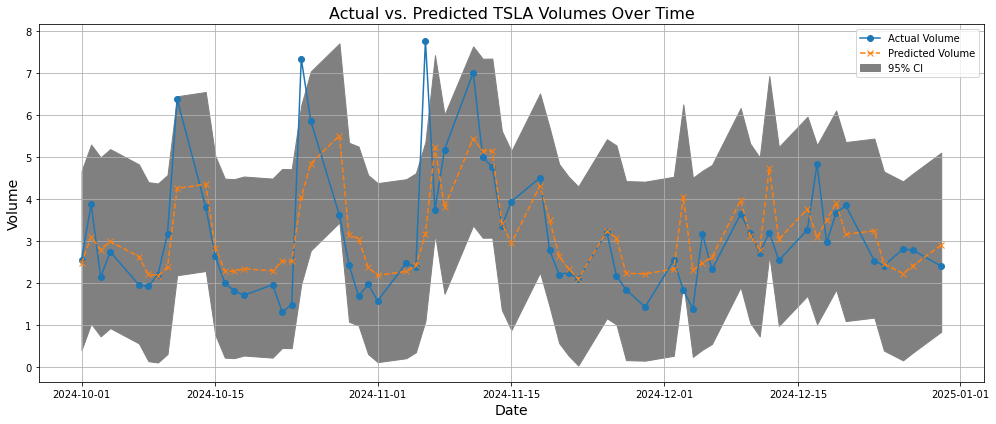

In [9]:
import numpy as np
import matplotlib.pyplot as plt
# Calculate residuals
residuals = np.array(all_predictions) - np.array(all_actuals)

# Calculate 95% Confidence Intervals
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)

ci_lower = mean_residual - 1.96 * std_residual
ci_upper = mean_residual + 1.96 * std_residual

print(f"\n95% Confidence Interval for Residuals: ({ci_lower}, {ci_upper})")

results_df['CI_Lower'] = results_df['Predicted_Volume'] + ci_lower
results_df['CI_Upper'] = results_df['Predicted_Volume'] + ci_upper

# Plot Actual vs. Predicted Volumes with Adjusted Confidence Intervals
plt.figure(figsize=(14, 6))
plt.plot(results_df['Date'], results_df['Actual_Volume'], label='Actual Volume', linestyle='-', marker='o')
plt.plot(results_df['Date'], results_df['Predicted_Volume'], label='Predicted Volume', linestyle='--', marker='x')
plt.fill_between(results_df['Date'], results_df['CI_Lower'], results_df['CI_Upper'], color='gray', label='95% CI')
plt.title('Actual vs. Predicted TSLA Volumes Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volume', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


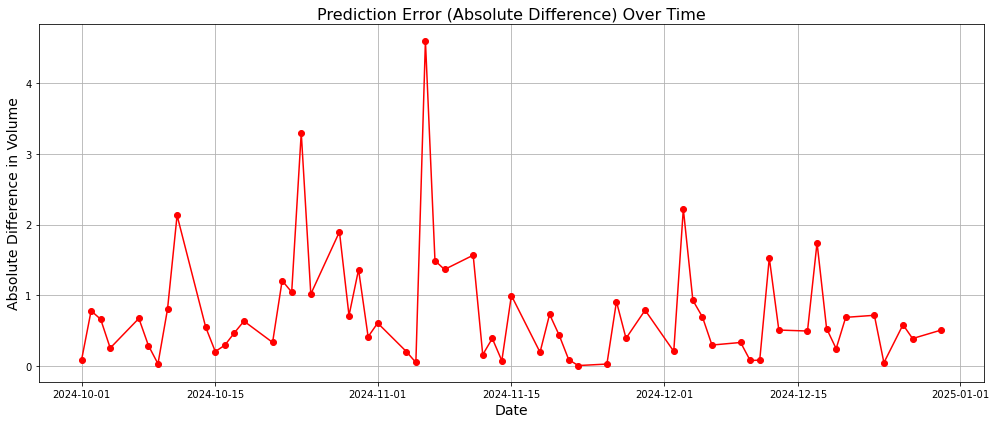

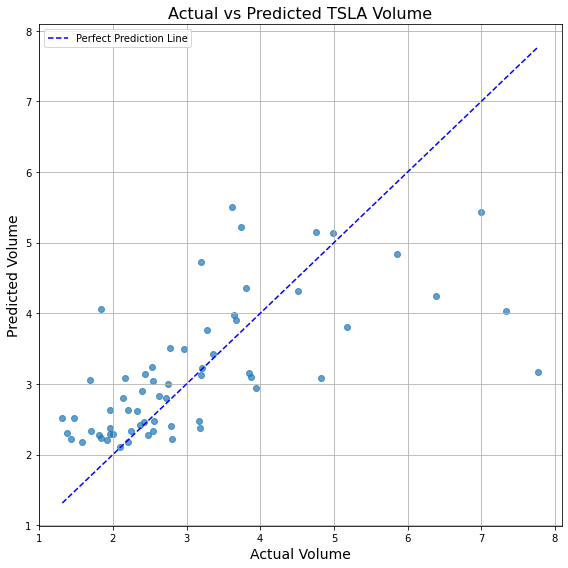

In [11]:
# Plot the Absolute Difference (Error) over time
plt.figure(figsize=(14, 6))
plt.plot(results_df['Date'], abs(results_df['Difference']), color='red', linestyle='-', marker='o')
plt.title('Prediction Error (Absolute Difference) Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Absolute Difference in Volume', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter Plot: Actual vs Predicted
plt.figure(figsize=(8, 8))
plt.scatter(results_df['Actual_Volume'], results_df['Predicted_Volume'], alpha=0.7)
plt.plot([results_df['Actual_Volume'].min(), results_df['Actual_Volume'].max()], 
         [results_df['Actual_Volume'].min(), results_df['Actual_Volume'].max()], 
         color='blue', linestyle='--', label='Perfect Prediction Line')
plt.title('Actual vs Predicted TSLA Volume', fontsize=16)
plt.xlabel('Actual Volume', fontsize=14)
plt.ylabel('Predicted Volume', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()